In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from tqdm.auto import tqdm
import matplotlib #change type 3 fonts:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Creating the system

$$
x_{t+1} = \alpha(x_t,e_t) x_t + u_t\\
\alpha(x_t, e_t) = 0.7 \exp(-(x+e)^2) + 0.3\\
y_t = x_t\\
e_t \sim \text{Unifrom}(-0.5, 0.5)\\
u_t \sim \text{Normal}(0, 2)
$$

In [2]:
def alpha(x, e): 
    A = 0.7
    return np.exp(-(x+e)**2)*A + (1-A)

def get_alpha_system_output(U, E=None, Escale=0.5, seed=2, x0 = 0): 
    # U is input sequence
    # either the noise sequence E can be given or
    # scale and seed can be given to create uniform noise between -scale to scale
    # x0 is the initial state
    x = x0
    if E is None:
        rng = np.random.RandomState(seed)
        E = rng.uniform(-Escale,Escale,size=np.array(U).shape)
    
    Y = []
    for ui,ei in zip(U,E):
        Y.append(x)
        x = alpha(x,ei)*x + ui
    return np.array(Y)

### Check how noisy $\alpha$ is as function of the amplitude of $e_t$

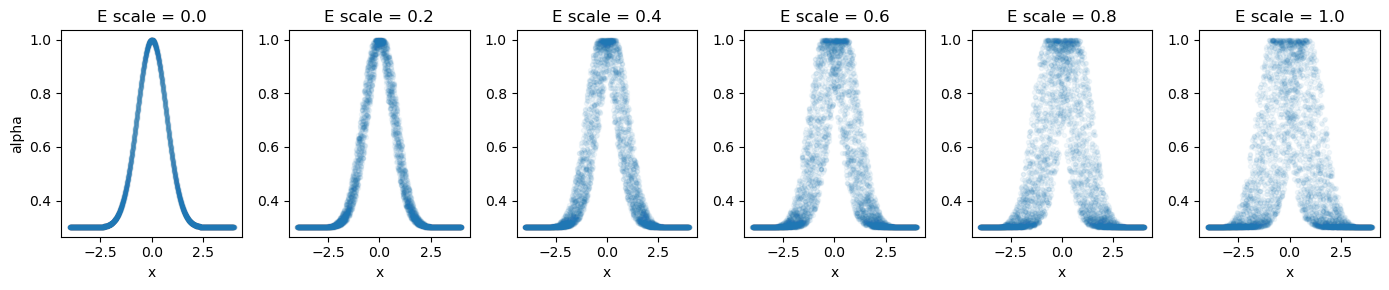

In [3]:
#check noise amplitude
#the alpha is noisy and I can show that
xtest = np.linspace(-4,4,num=5000)
Escales = np.linspace(0,1.0,num=6) 
plt.figure(figsize=(14,3))
for i,Escale in enumerate(Escales, start=1):
    plt.subplot(1,len(Escales),i)
    E = np.random.uniform(-Escale,Escale,size=xtest.shape)
    plt.plot(xtest,alpha(xtest,E),'.', alpha=0.05)
    plt.xlabel('x'); 
    if i==1:
        plt.ylabel('alpha')
    plt.title(f'E scale = {Escale:.2}')
plt.tight_layout()
plt.show()


### Selecte $e_t$ noise scale by checking signal to noise

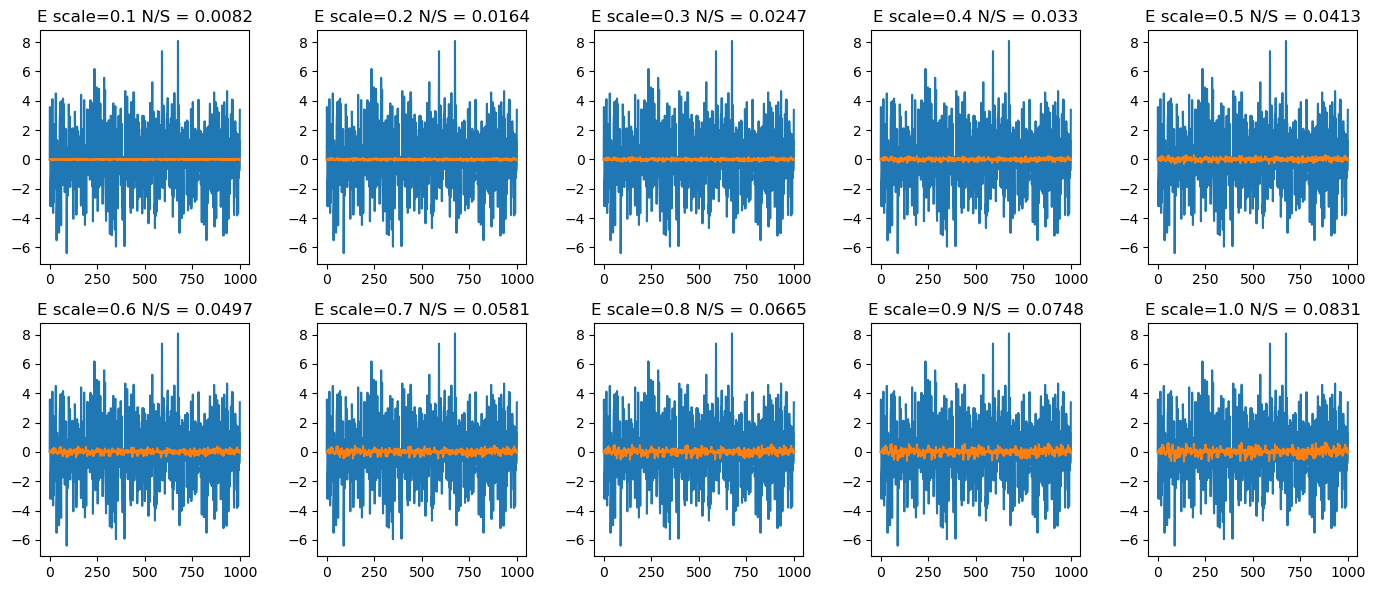

In [4]:
Uscale = 2
rng_u = np.random.RandomState(3)
U = rng_u.normal(scale=Uscale, size=1000)
Y0 = get_alpha_system_output(U, Escale=0) #no noise
Escales = np.linspace(0, 1.0, 11)[1:]
plt.figure(figsize=(14,6))
for i,Escale in enumerate(Escales, start=1):
    plt.subplot(2,len(Escales)//2, i)
    Y = get_alpha_system_output(U, Escale=Escale)
    plt.title(f'E scale={Escale:.2} N/S = {np.mean((Y-Y0)**2)**0.5/np.std(Y0):.3}')
    plt.plot(Y0)
    plt.plot(Y-Y0)
plt.tight_layout()
plt.show()
Escale = 0.5 #4.1% noise to signal

### Convergence check

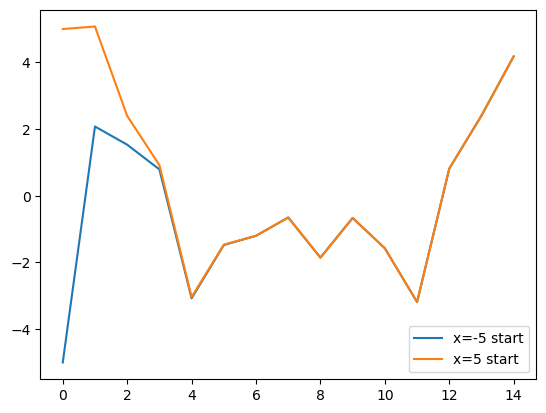

In [5]:
#check convergence speed
E = np.random.uniform(-Escale,Escale,size=xtest.shape)
Ym5 = get_alpha_system_output(U, E, x0=-5)[:15]
Y5 = get_alpha_system_output(U, E, x0=5)[:15]
plt.plot(Ym5)
plt.plot(Y5)
plt.legend(['x=-5 start','x=5 start'])
plt.show()

# Training validation and test set Generation

In [6]:
rng_u = np.random.RandomState(3)
Utrain = rng_u.normal(scale=Uscale, size=300_000)
Ytrain = get_alpha_system_output(Utrain, seed=101)

rng_u = np.random.RandomState(4)
Uval = rng_u.normal(scale=Uscale, size=10_000)
Yval = get_alpha_system_output(Uval, seed=102)

rng_u = np.random.RandomState(5) #is not used
Utest = rng_u.normal(scale=Uscale, size=20_000)
Ytest = get_alpha_system_output(Utest, seed=103)

### Repeated Experiments

In [7]:
rng_u = np.random.RandomState(33)
repeated_lenght = 4100
repeated_same = 0

Urepeated = rng_u.normal(scale=Uscale, size=repeated_lenght)
rng_e = np.random.RandomState(35)
Erepeated = rng_e.uniform(-Escale, Escale, size=Urepeated.shape) #change on the fly
Y0repaeted = get_alpha_system_output(Urepeated, Erepeated)
Yrepeated = []
Nrepeats = 5000
for _ in tqdm(range(Nrepeats)):
    Erepeated[repeated_same:] = rng_e.uniform(-Escale, Escale, size=Urepeated.shape[0]-repeated_same) #it gets different after 100 samples
    Yrepeated.append(get_alpha_system_output(Urepeated, Erepeated))
Yrepeated = np.array(Yrepeated) #(instance, time)

# plt.plot(Yrepeated.T-np.mean(Yrepeated,axis=0)[:,None],'r',alpha=1/Nrepeats*10)
# plt.xlim(90,130)
# plt.show()

  0%|          | 0/5000 [00:00<?, ?it/s]

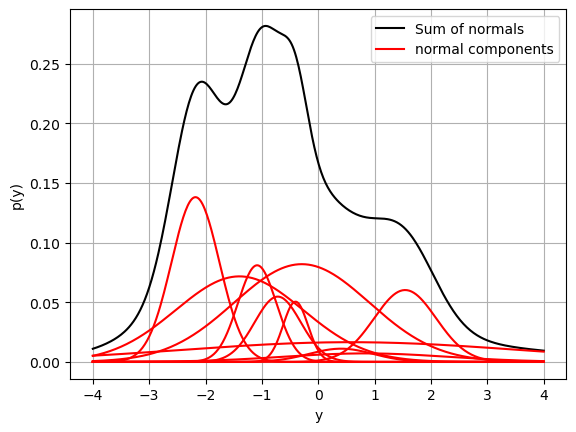

In [8]:
from fancy_distributions import Multimodal_Normal
nw = 10
torch.manual_seed(0)
loc = torch.randn(nw)
scale = torch.randn(nw)
scale = torch.exp(scale)
weights = torch.randn(nw)
weights = torch.exp(weights)
weights /= torch.sum(weights)
dist = Multimodal_Normal(loc, scale, weights)
ytest = torch.linspace(-4,4,400)
py = dist.prob(ytest).numpy()
pyw = dist.prob_per_weighted(ytest).numpy()
plt.plot(ytest.numpy(), py,'k')
plt.plot(ytest.numpy(), pyw,'r')
plt.legend(['Sum of normals','normal components'])
plt.grid()
plt.xlabel('y')
plt.ylabel('p(y)')
plt.savefig('./figures/sum-normal.png',dpi=300)
plt.savefig('./figures/sum-normal.pdf',dpi=300)
plt.show()


## Train or load model

In [9]:
from meta_SS_models import Meta_SS_model_encoder, get_nuy_and_auto_norm, Meta_SS_model
import pickle, os

load = True
name = 'alpha-nz-3'
burn_time = 10
n_weights = 30
nz = 3

name = 'models/'+name
if not load and (not os.path.exists(name) or input(f'{name} already exists? continue Y/[N]')=='Y'):
    sys = Meta_SS_model(*get_nuy_and_auto_norm(Utrain, Ytrain), nz=nz, n_weights=n_weights)
    sys.fit((Utrain, Ytrain), (Uval, Yval), iterations=1_000_000, batch_size=2048, \
            loss_kwargs=dict(nf=30, parameter_init=False, burn_time=burn_time), \
            loss_kwargs_val=dict(nf=50, parameter_init=False, burn_time=20), print_freq=1000)
    pickle.dump(sys, open(name,'wb'))
else:
    sys = pickle.load(open(name,'rb'))

## Compare different models:

In [10]:
for name in sorted(os.listdir('./models/')):
    sys = pickle.load(open('./models/'+name,'rb'))
    Z = 1000
    M = 100 #skip 100 samples to remove transient
    M2 = 100
    k0 = max(sys.na, sys.nb) if isinstance(sys, Meta_SS_model_encoder) else 0
    test_res = sys.multi_step((Utest[M-k0:Z], Ytest[M-k0:Z]), nf=Z-M)
    nlogp = np.mean(test_res.log_prob(time_average=False)[M2:])
    print(f'{name}  normlogp={nlogp:.5}')

alpha-nz-2  normlogp=1.408
alpha-nz-3  normlogp=1.4941
alpha-nz-4  normlogp=1.4967


minimal difference between nz=3 and nz=4

In [11]:
sys = pickle.load(open('models/alpha-nz-3','rb'))
# sys = pickle.load(open('models/alpha-nz-2','rb'))
# sys = pickle.load(open('models/alpha-nz-4','rb'))

In [12]:
M = 100 #skip 100 samples to remove transient
k0 = max(sys.na, sys.nb) if isinstance(sys, Meta_SS_model_encoder) else 0
test_res = sys.multi_step((Utest[M-k0:], Ytest[M-k0:]), nf=len(Utest)-M)

logp static mean and static std -2.178906
logp dynamic mean and static std 1.0367852
logp dynamic mean and dyanmic std 1.5598997
logp meta state space model 1.6743244
logp noise floor est 1.7301976024954193


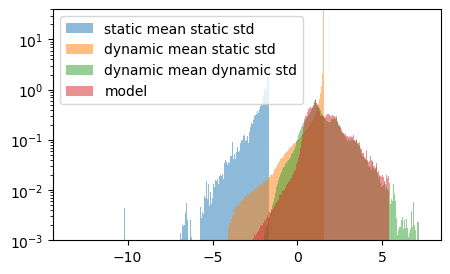

In [13]:
from torch import distributions

trans = 100
Yrepeated_small = Yrepeated[:,repeated_same+trans:]
Normal = distributions.normal.Normal
as_ten = lambda x: torch.as_tensor(x, dtype=torch.float32)
# def get_base_logs
# we can get constant 
Yrepeated_std = np.std(Yrepeated_small, axis=0)
Yrepeated_mean = np.mean(Yrepeated_small, axis=0)
Yrepated_static_std = np.std(Yrepeated_small-Yrepeated_mean[None,:]) #given a dynamic mean what 


static_mean_static_std = Normal(as_ten(np.mean(Yrepeated_small)), as_ten(np.std(Yrepeated_small)))

dynamic_mean_static_std = Normal(as_ten(Yrepeated_mean), \
                            torch.broadcast_to(as_ten(Yrepated_static_std), Yrepeated_mean.shape))

dynamic_mean_dynamic_std = Normal(as_ten(Yrepeated_mean), \
                            as_ten(Yrepeated_std))

logp_dynamic_mean_dynamic_std = dynamic_mean_dynamic_std.log_prob(as_ten(Yrepeated_small)).numpy().flatten()
logp_dynamic_mean_static_std = dynamic_mean_static_std.log_prob(as_ten(Yrepeated_small)).numpy().flatten()
logp_static_mean_static_std = static_mean_static_std.log_prob(as_ten(Yrepeated_small)).numpy().flatten()

logp_dynamic_mean_dynamic_std_m = np.mean(logp_dynamic_mean_dynamic_std)
logp_dynamic_mean_static_std_m = np.mean(logp_dynamic_mean_static_std)
logp_static_mean_static_std_m = np.mean(logp_static_mean_static_std)


## model
re_res = sys.multi_step((Urepeated,Y0repaeted), nf=len(Urepeated))
re_logp = re_res.y_dists[0,repeated_same+trans:].log_prob(as_ten(Yrepeated[:,repeated_same+trans:]))
torch.mean(re_logp).item()
logp_meta_state_model = re_logp.numpy().flatten()
logp_meta_state_model_m = logp_meta_state_model.mean()
print('logp static mean and static std',logp_static_mean_static_std_m)
print('logp dynamic mean and static std',logp_dynamic_mean_static_std_m)
print('logp dynamic mean and dyanmic std',logp_dynamic_mean_dynamic_std_m)
print('logp meta state space model',logp_meta_state_model_m)


from scipy import stats
## upper limit:
diff_S_logp = [-stats.differential_entropy(Yrt) for Yrt in Yrepeated_small.T]
diff_S_logp_mean = np.mean(diff_S_logp) 
print('logp noise floor est', diff_S_logp_mean)

plt.figure(figsize=(5,3))
plt.hist(logp_static_mean_static_std,bins=int(logp_dynamic_mean_static_std.size**0.5),density=True,alpha=0.5)
plt.hist(logp_dynamic_mean_static_std,bins=int(logp_dynamic_mean_static_std.size**0.5),density=True,alpha=0.5)
plt.hist(logp_dynamic_mean_dynamic_std,bins=int(logp_dynamic_mean_dynamic_std.size**0.5),density=True,alpha=0.5)
plt.hist(logp_meta_state_model,bins=int(logp_meta_state_model.size**0.5),density=True,alpha=0.5)
plt.semilogy()
plt.ylim(1e-3, 40)
plt.legend(['static mean static std', 'dynamic mean static std', 'dynamic mean dynamic std', 'model'], loc='upper left')
plt.show()

In [14]:
# the model has some minor model error when the distributions have a low std (high log p)

  0%|          | 0/6 [00:00<?, ?it/s]

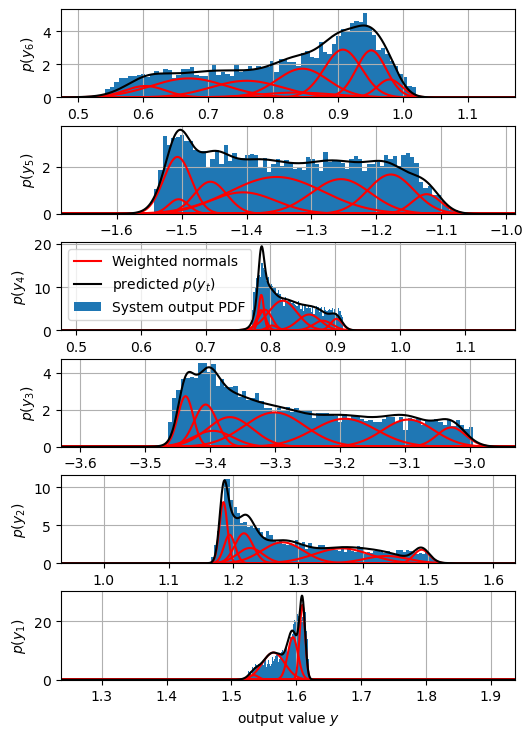

  0%|          | 0/3 [00:00<?, ?it/s]

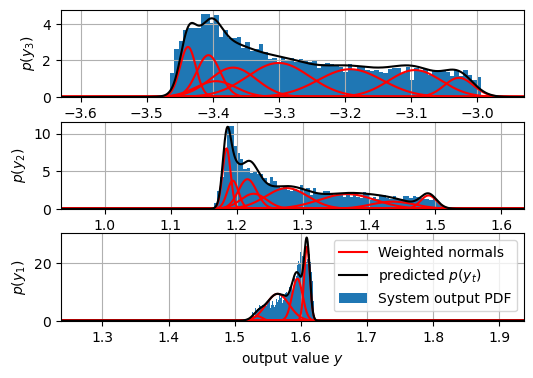

In [15]:
Z0 = 35
M = 100
k0 = max(sys.na, sys.nb) if isinstance(sys, Meta_SS_model_encoder) else 0
del sys.init_z
sys.checkpoint_load('lowest_val_loss')

res = sys.multi_step((Urepeated[M-k0:],Y0repaeted[M-k0:]), nf=len(Urepeated)-M)

# fig_i = 90
for Nfigs in [6,3]:


    plt.figure(figsize=(1.3*4,1.2*Nfigs))
    for fig_i in tqdm(range(Z0,Z0+Nfigs)):
        for K in range(3,4):
            ax = plt.subplot(Nfigs, 1, 1*(Nfigs-(fig_i - Z0)) + (K-3))
            Yslice = Yrepeated[:,M+fig_i]
            Ymean = np.mean(Yslice)
            plt.hist(Yslice,density=True,bins=int(len(Yslice)**0.5),label='System output PDF')
        #     print('diff Y', res.yfuture[0,fig_i].numpy()-Y0[M+fig_i]) #debug
            if K==2:
                xlim = plt.xlim()#-2.5,2.5)
            elif K==1:
                xlim = plt.xlim(-3,3)
            elif K==3:
                ymean = np.mean(Yslice)
                xlim = plt.xlim(ymean-0.35,ymean+0.35)
            else:
                assert False

            ytest = torch.linspace(*xlim,steps=3000)
            for i,sub_normal in enumerate(res.y_dists[0,fig_i].prob_per_weighted(ytest).numpy().T):
                plt.plot(ytest.numpy(),sub_normal,'r',label='Weighted normals' if i==0 else None)
            plt.plot(ytest.numpy(),res.y_dists[0,fig_i].prob(ytest).numpy(),'k',label='predicted $p(y_t)$')
            plt.xlim(xlim)
            plt.ylabel(f'$p(y_{str(fig_i-34)})$')
            if K==1:
                xlim = plt.ylim(0,4)#-2.5,2.5)
            plt.grid()
            if fig_i!=Z0+Nfigs-1 and K==1:
                ax.set_xticklabels([])
            if fig_i==35:
                plt.xlabel('output value $y$')
            if fig_i==38 or (Nfigs==3 and fig_i==35):
                plt.legend()
    plt.tight_layout(pad=0.06)
    m = '' if Nfigs == 6 else f'-{Nfigs}'
    plt.savefig(f'./figures/hist-and-y-dists{m}.png',dpi=300)
    plt.savefig(f'./figures/hist-and-y-dists{m}.pdf',dpi=300)
    plt.show()
